In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02516/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

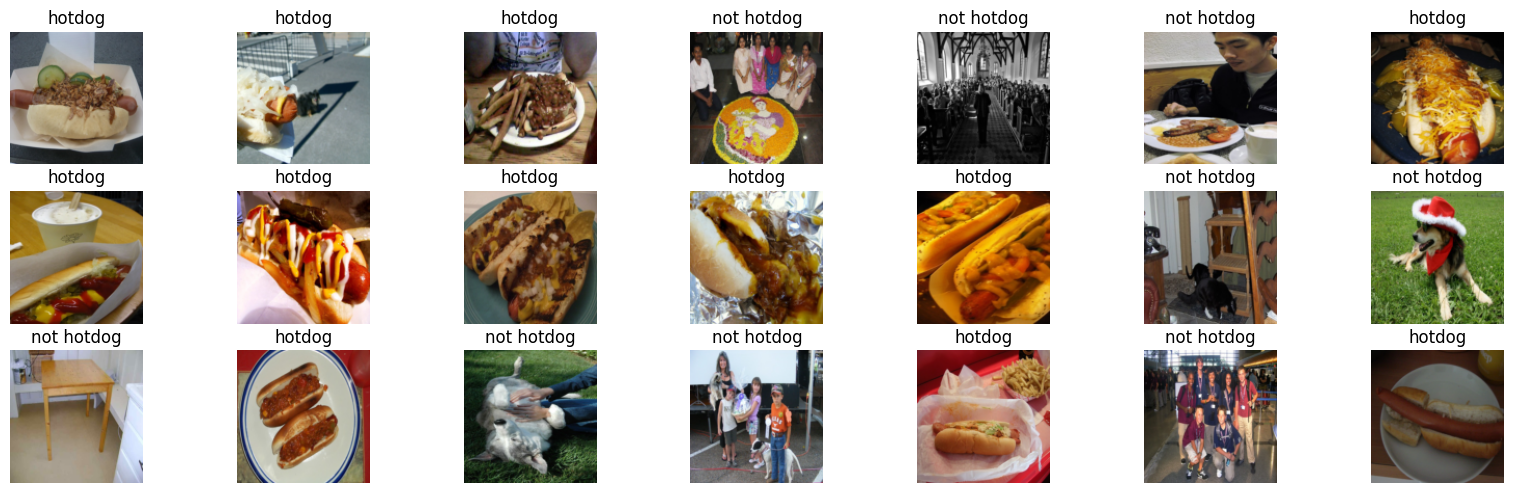

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

Now create a model and train it!


In [6]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from PIL import Image
import os
import glob


# Instantiate the VGG19 model without pretrained weights
model = models.vgg19(weights=True) # not pretrained


# Modify the classifier for your specific task
# Example: Replace the final fully connected layer for binary classification
model.classifier[6] = nn.Linear(4096, 2)  # Change 2 to the number of classes in your dataset

# Set device and define loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
epochs = 5
for epoch in range(epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate the model on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

/zhome/74/d/146610/venv_M/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy: 92.00%


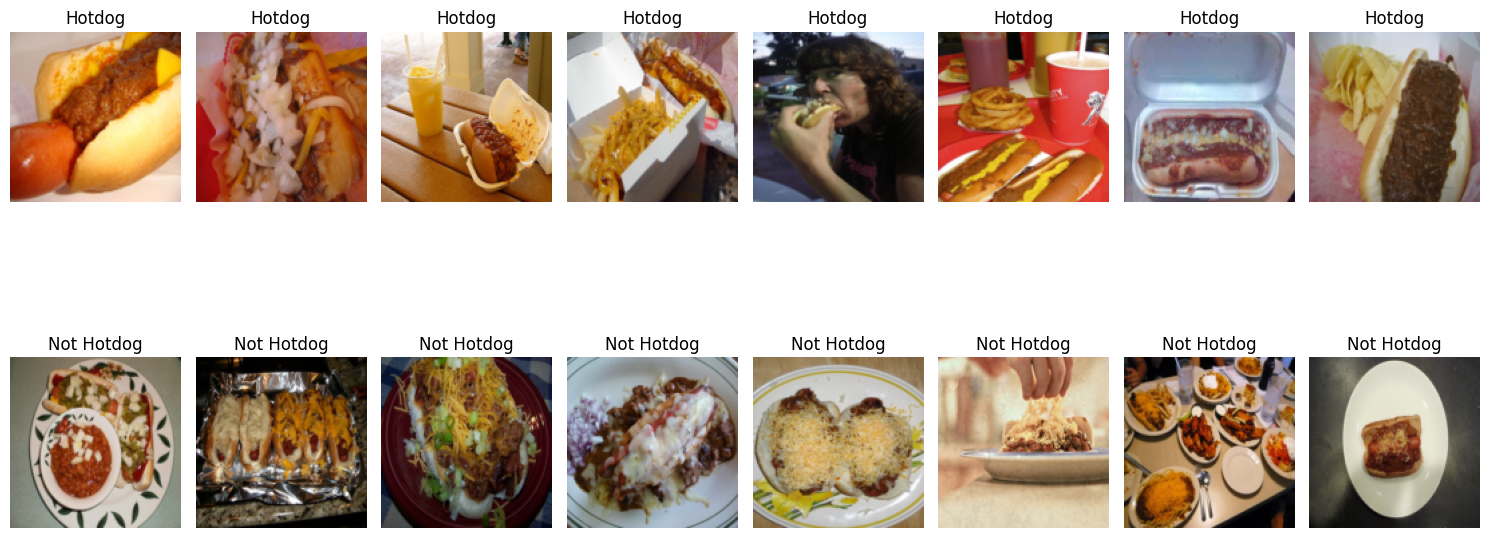

In [7]:
# Evaluate the model on a few test samples and plot their predicted labels for both classes
model.eval()

# Initialize counters for each class to keep track of printed samples
hotdog_samples = 0
nothotdog_samples = 0

plt.figure(figsize=(15, 8))

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(inputs)):
            if hotdog_samples >= 8 and nothotdog_samples >= 8:  # Plot 8 hotdog and 8 nothotdog samples
                break

            image = transforms.functional.to_pil_image(inputs[i])  # Convert tensor back to PIL image

            # Check the predicted label and plot accordingly for both classes
            if predicted[i] == 0 and hotdog_samples < 8:  # Predicted as hotdog
                plt.subplot(2, 8, hotdog_samples + 1)
                plt.imshow(image)
                plt.title('Hotdog')
                plt.axis('off')
                hotdog_samples += 1

            elif predicted[i] == 1 and nothotdog_samples < 8:  # Predicted as not hotdog
                plt.subplot(2, 8, 8 + nothotdog_samples + 1)
                plt.imshow(image)
                plt.title('Not Hotdog')
                plt.axis('off')
                nothotdog_samples += 1

        if hotdog_samples >= 8 and nothotdog_samples >= 8:  # Stop after 8 hotdog and 8 nothotdog samples
            break

plt.tight_layout()
plt.show()

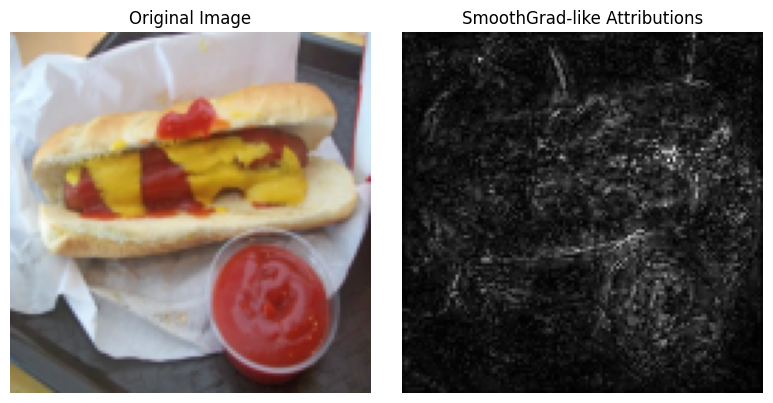

In [24]:
import random

# Define the path to the test folder
test_folder_path = '/dtu/datasets1/02516/hotdog_nothotdog/test'

# Get a list of all image paths in the test folder
test_image_paths = glob.glob(test_folder_path + '/*/*.jpg')

# Randomly select an image path
random_image_path = random.choice(test_image_paths)

# Load the image and apply the same transformation used in your dataset
transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])
image = load_image(random_image_path, transform)

# Enable gradients for the input image
image.requires_grad = True

# Forward pass to get model prediction
output = model(image.to(device))

# Choose the target class (label) for which you want to compute SmoothGrad
target_label = torch.argmax(output, dim=1).item()  # Use the predicted label as the target

# Calculate gradients with respect to the target class output
output[0, target_label].backward()

# Get gradients from the image
gradients = image.grad.detach().cpu().numpy()

# Compute SmoothGrad-like attributions by averaging gradients across multiple perturbed images
smooth_grad_iterations = 50  # Number of iterations for SmoothGrad
smooth_grad_sigma = 0.1  # Standard deviation for noise perturbation

smoothed_gradients = []
for _ in range(smooth_grad_iterations):
    noise = np.random.normal(0, smooth_grad_sigma, size=image.shape).astype(np.float32)
    perturbed_image = image.detach().cpu().numpy() + noise
    perturbed_image = torch.from_numpy(perturbed_image).to(device)
    perturbed_image.requires_grad = True

    output = model(perturbed_image)
    output[0, target_label].backward()

    perturbed_gradients = perturbed_image.grad.detach().cpu().numpy()
    smoothed_gradients.append(perturbed_gradients)

smoothed_gradients = np.mean(smoothed_gradients, axis=0)

# Plot the original image and its attributions from SmoothGrad
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(transforms.functional.to_pil_image(image.squeeze(0).cpu()))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.abs(smoothed_gradients.squeeze(0)).sum(axis=0), cmap='gray')
plt.title('SmoothGrad-like Attributions')
plt.axis('off')

plt.tight_layout()
plt.show()

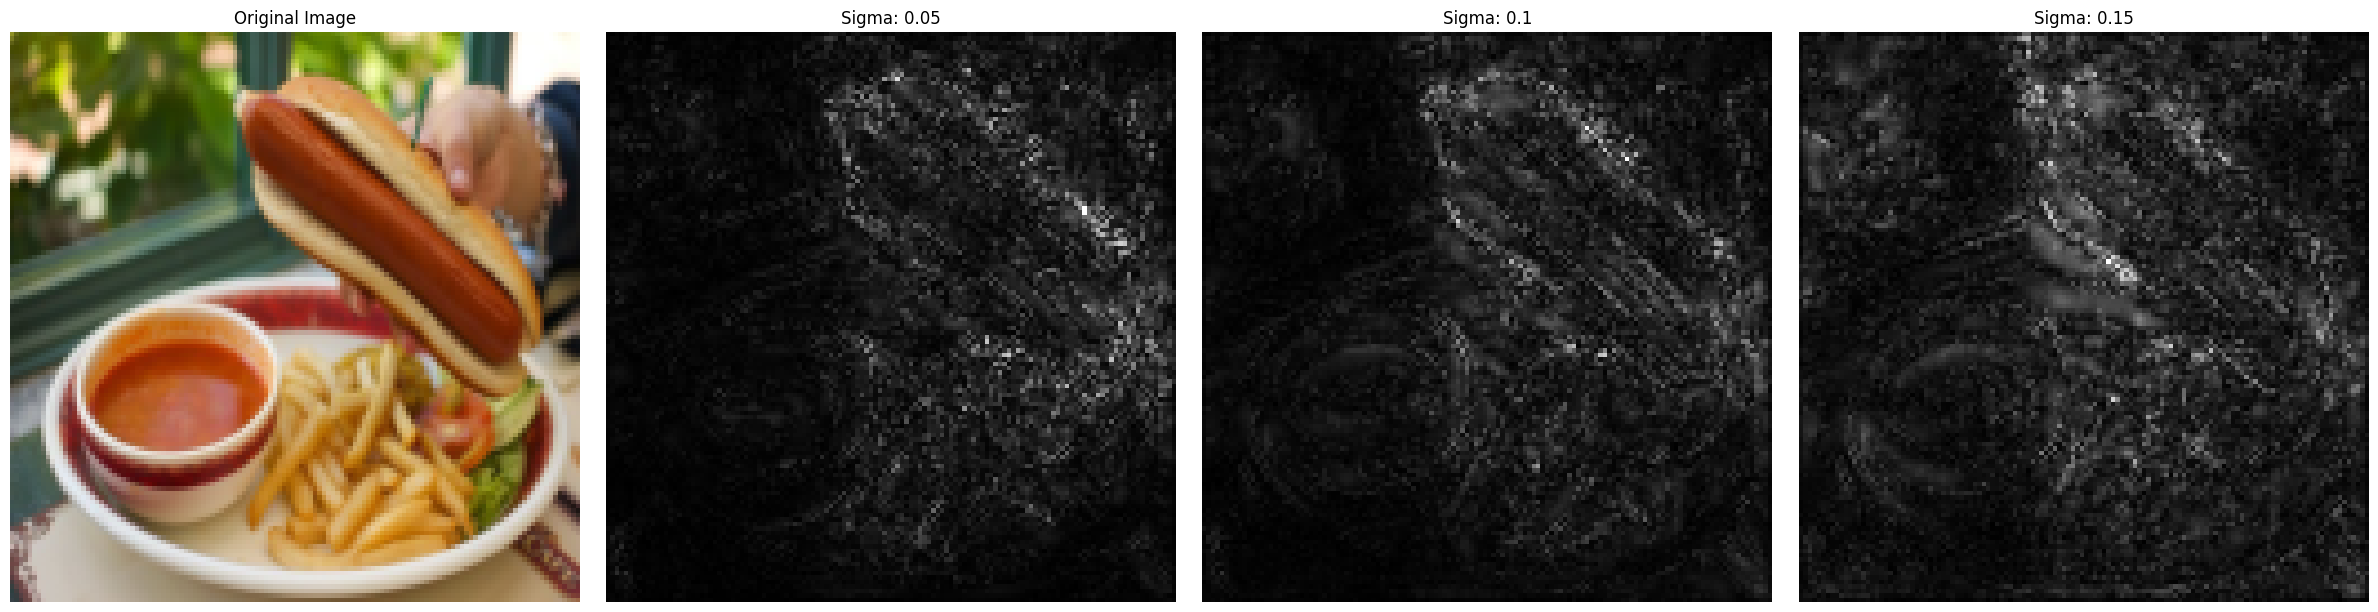

In [25]:
import random

# Define the path to the test folder
test_folder_path = '/dtu/datasets1/02516/hotdog_nothotdog/test'

# Get a list of all image paths in the test folder
test_image_paths = glob.glob(test_folder_path + '/*/*.jpg')

# Randomly select an image path
random_image_path = random.choice(test_image_paths)

# Load the image and apply the same transformation used in your dataset
transform = transforms.Compose([transforms.Resize((size, size)), transforms.ToTensor()])
image = load_image(random_image_path, transform)

# Enable gradients for the input image
image.requires_grad = True

# Forward pass to get model prediction
output = model(image.to(device))

# Choose the target class (label) for which you want to compute SmoothGrad
target_label = torch.argmax(output, dim=1).item()  # Use the predicted label as the target

# Calculate gradients with respect to the target class output
output[0, target_label].backward()

# Get gradients from the image
gradients = image.grad.detach().cpu().numpy()

# Define different standard deviations for noise perturbation
sigma_values = [0.05, 0.1, 0.15]  # You can adjust or add more sigma values here

# Initialize a list to store SmoothGrad-like attributions for different sigmas
smoothed_gradients_list = []

# Compute SmoothGrad-like attributions for each sigma value
for sigma in sigma_values:
    smoothed_gradients = []
    smooth_grad_iterations = 50  # Number of iterations for SmoothGrad

    for _ in range(smooth_grad_iterations):
        noise = np.random.normal(0, sigma, size=image.shape).astype(np.float32)
        perturbed_image = image.detach().cpu().numpy() + noise
        perturbed_image = torch.from_numpy(perturbed_image).to(device)
        perturbed_image.requires_grad = True

        output = model(perturbed_image)
        output[0, target_label].backward()

        perturbed_gradients = perturbed_image.grad.detach().cpu().numpy()
        smoothed_gradients.append(perturbed_gradients)

    smoothed_gradients = np.mean(smoothed_gradients, axis=0)
    smoothed_gradients_list.append((smoothed_gradients, sigma))

# Plot the original image and SmoothGrad-like attributions for different sigma values
plt.figure(figsize=(8 * len(sigma_values), 6))

# Plot the original image
plt.subplot(1, len(sigma_values) + 1, 1)
plt.imshow(transforms.functional.to_pil_image(image.squeeze(0).cpu()))
plt.title('Original Image')
plt.axis('off')

# Plot SmoothGrad-like attributions for different sigmas
for i, (smoothed_gradients, sigma) in enumerate(smoothed_gradients_list):
    plt.subplot(1, len(sigma_values) + 1, i + 2)
    plt.imshow(np.abs(smoothed_gradients.squeeze(0)).sum(axis=0), cmap='gray')
    plt.title(f'Sigma: {sigma}')
    plt.axis('off')

plt.tight_layout()
plt.show()
